In [1]:
#We get all dependencis we need for a Random Forest
#If you need a module do: "!pip install [module_name]""
import numpy as np
import pandas as pd
import secrets
import matplotlib.pylab as plt
import itertools
import pydot
import pickle
import sys

from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from collections import Counter
from subprocess import call
from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_graphviz

In [2]:
# Get the URL of the video we want to create highlights on
url = "https://www.youtube.com/watch?v=xqtZf2dIZzQ"
vidId = url.replace('https://www.youtube.com/watch?v=', '')

In [3]:
# Get the data extracted from our video
db_conn_str = "mysql+pymysql://{:}:{:}@{:}/{:}".format(secrets.user, secrets.password, secrets.host, secrets.db)
db_conn = create_engine(db_conn_str)
df = pd.read_sql('SELECT * FROM clips WHERE url ="'+ url +'"', con=db_conn)

print('Number of Rows:', len(df.index))
db_conn.dispose()

Number of Rows: 1603


In [4]:
features_df = df[['pitch', 'amplitude', 'subjectivity', 'polarity', 'pred_excitement']]

In [5]:
# Separate our tags and features
X = features_df
X.head()

,pitch,amplitude,subjectivity,polarity,pred_excitement
0,58.9881,-0.000314,0.000000,0.000000,1
1,62.4685,0.000153,0.000000,0.000000,0
2,61.2615,-0.000189,0.068182,0.072727,0
3,63.7713,-0.000578,0.033333,0.033333,0
4,66.3894,0.000076,0.050376,0.031579,0


In [6]:
# Get model predictions
rf_predictions = df['pred_highlight_rf']
nn_predictions = df['pred_highlight_nn']

In [7]:
# get youtube embeded url
def formatYoutubeUrl(url, start, end):
  embed_url = url.replace("watch?v=", "embed/")
  params = "?start={:}&end={:}&autoplay=1".format(start, end)
  return embed_url + params

def printUrls(df):
    for idx, row in df.iterrows():
        print(formatYoutubeUrl(row['url'], row['start'], row['end']))

In [8]:
# all non-highlight clips
non_highlight_rf = df[df['pred_highlight_rf'] == 0]
non_highlight_nn = df[df['pred_highlight_nn'] == 0]

# all non-highlight clips
highlight_rf = df[df['pred_highlight_rf'] == 1]
highlight_nn = df[df['pred_highlight_nn'] == 1]

# print URLs
print('=== NON-HIGHLIGHT RF ===')
printUrls(non_highlight_rf.sample(20))

print('=== HIGHLIGHT RF ===')
printUrls(highlight_rf.sample(20))

print('=== NON-HIGHLIGHT NN ===')
printUrls(non_highlight_nn.sample(20))

print('=== HIGHLIGHT NN ===')
printUrls(highlight_nn.sample(20))

=== NON-HIGHLIGHT RF ===
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2888&end=2892&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1344&end=1348&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2400&end=2404&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=8&end=12&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1384&end=1388&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1548&end=1552&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1314&end=1318&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2418&end=2422&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=372&end=376&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=834&end=838&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=54&end=58&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=524&end=528&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=420&end=424&autoplay=1
https://www.youtube.com/embed/xqtZf2dIZzQ?s

In [9]:
# Output Predictions vs Actual results
for idx, row in df.iterrows():
    print(formatYoutubeUrl(row['url'], row['start'], row['end']), "Predicted RF: " ,row['pred_highlight_rf'], "Predicted NN: " ,row['pred_highlight_nn'])

https://www.youtube.com/embed/xqtZf2dIZzQ?start=0&end=4&autoplay=1 Predicted RF:  1 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2&end=6&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=4&end=8&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=6&end=10&autoplay=1 Predicted RF:  1 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=8&end=12&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=10&end=14&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=12&end=16&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=14&end=18&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=16&end=20&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=18&end=22&autoplay=1 Predicted RF

https://www.youtube.com/embed/xqtZf2dIZzQ?start=260&end=264&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=262&end=266&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=264&end=268&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=266&end=270&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=268&end=272&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=270&end=274&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=272&end=276&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=274&end=278&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=276&end=280&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=278&end

https://www.youtube.com/embed/xqtZf2dIZzQ?start=584&end=588&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=586&end=590&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=588&end=592&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=590&end=594&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=592&end=596&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=594&end=598&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=596&end=600&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=598&end=602&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=600&end=604&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=602&end

https://www.youtube.com/embed/xqtZf2dIZzQ?start=774&end=778&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=776&end=780&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=778&end=782&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=780&end=784&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=782&end=786&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=784&end=788&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=786&end=790&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=788&end=792&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=790&end=794&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=792&end

https://www.youtube.com/embed/xqtZf2dIZzQ?start=998&end=1002&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1000&end=1004&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1002&end=1006&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1004&end=1008&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1006&end=1010&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1008&end=1012&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1010&end=1014&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1012&end=1016&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1014&end=1018&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dI

https://www.youtube.com/embed/xqtZf2dIZzQ?start=1266&end=1270&autoplay=1 Predicted RF:  1 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1268&end=1272&autoplay=1 Predicted RF:  1 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1270&end=1274&autoplay=1 Predicted RF:  1 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1272&end=1276&autoplay=1 Predicted RF:  1 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1274&end=1278&autoplay=1 Predicted RF:  1 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1276&end=1280&autoplay=1 Predicted RF:  1 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1278&end=1282&autoplay=1 Predicted RF:  1 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1280&end=1284&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1282&end=1286&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2d

https://www.youtube.com/embed/xqtZf2dIZzQ?start=1458&end=1462&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1460&end=1464&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1462&end=1466&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1464&end=1468&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1466&end=1470&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1468&end=1472&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1470&end=1474&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1472&end=1476&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1474&end=1478&autoplay=1 Predicted RF:  0 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2d

https://www.youtube.com/embed/xqtZf2dIZzQ?start=1690&end=1694&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1692&end=1696&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1694&end=1698&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1696&end=1700&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1698&end=1702&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1700&end=1704&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1702&end=1706&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1704&end=1708&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1706&end=1710&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2d

https://www.youtube.com/embed/xqtZf2dIZzQ?start=1890&end=1894&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1892&end=1896&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1894&end=1898&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1896&end=1900&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1898&end=1902&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1900&end=1904&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1902&end=1906&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1904&end=1908&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=1906&end=1910&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2d

https://www.youtube.com/embed/xqtZf2dIZzQ?start=2224&end=2228&autoplay=1 Predicted RF:  0 Predicted NN:  1
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2226&end=2230&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2228&end=2232&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2230&end=2234&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2232&end=2236&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2234&end=2238&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2236&end=2240&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2238&end=2242&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2240&end=2244&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2d

https://www.youtube.com/embed/xqtZf2dIZzQ?start=2556&end=2560&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2558&end=2562&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2560&end=2564&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2562&end=2566&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2564&end=2568&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2566&end=2570&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2568&end=2572&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2570&end=2574&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2572&end=2576&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2d

https://www.youtube.com/embed/xqtZf2dIZzQ?start=2816&end=2820&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2818&end=2822&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2820&end=2824&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2822&end=2826&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2824&end=2828&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2826&end=2830&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2828&end=2832&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2830&end=2834&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=2832&end=2836&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2d

https://www.youtube.com/embed/xqtZf2dIZzQ?start=3076&end=3080&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=3078&end=3082&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=3080&end=3084&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=3082&end=3086&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=3084&end=3088&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=3086&end=3090&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=3088&end=3092&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=3090&end=3094&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2dIZzQ?start=3092&end=3096&autoplay=1 Predicted RF:  0 Predicted NN:  0
https://www.youtube.com/embed/xqtZf2d

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time

def secondsToTime(secs):
    m, s = divmod(secs, 60)
    return "{:}:{:}".format(m, s)

def realTimeHypeGraph(df):
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    plt.ion()

    fig.show()
    fig.canvas.draw()

    x = []
    y1 = []
    y2 = []
    y3 = []
    
    plt.tight_layout()
    plt.subplots_adjust(wspace = 0.2)
    
    for idx, row in df.iterrows():
        ax1.clear()
        ax1.set_ylim([-0.5, 2.5])
        ax2.clear()
        ax2.set_ylim([-0.5, 2.5])
        
        videoTime = row['start'] / 60
        x.append(videoTime)
        y1.append(row['pred_highlight_rf'])
        y2.append(row['pred_highlight_nn'] + 0.02)
        y3.append(row['pred_excitement'])

        ax1.plot(x[-20:], y1[-20:], label='random_forest', alpha=0.7)
        ax1.plot(x[-20:], y2[-20:], label='neural_network', alpha=0.7)
        ax2.plot(x[-20:], y3[-20:], label='predict_excitement', alpha=0.9, color='red')
        
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Highlight')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Excitement')
        
        ax1.legend(loc="upper right")
        ax2.legend(loc="upper right")
        
        fig.canvas.draw()
        time.sleep(2)

In [11]:
from IPython.display import HTML

youtubeEmbedUrl = url.replace('watch?v=', 'embed/')
# Youtube
HTML("<iframe width='560' height='315' src='{:}'</iframe>".format(youtubeEmbedUrl))

C:\Users\eldri\Anaconda3\lib\site-packages\IPython\core\display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


<IPython.core.display.Javascript object>


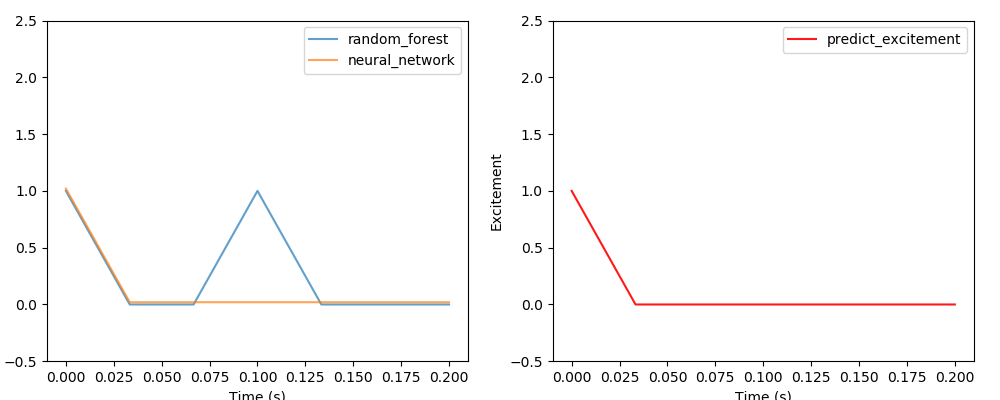

KeyboardInterrupt: 

In [12]:
# run this cell right before you click play on the youtube video
# Also run starting at
dataset = df[df['start'] >= 0] # you can customize the start time here
realTimeHypeGraph(dataset)

In [ ]:
# Display our highlight reel
highlight_url = "https://www.youtube.com/watch?v=y4LABn8RNT0&fbclid=IwAR1v7yEFpuApcZnBE5Ze0fJ3efwTxSN2euBVSXrX8qg9ed_NgKNdi2MDP08"